<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5Dgraph_split_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install node2vec
!pip install stellargraph

In [117]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx
import stellargraph as sg
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from sklearn.manifold import TSNE

from node2vec import Node2Vec

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve
from sklearn.model_selection import validation_curve, learning_curve

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')
import pickle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Upload a graph created in the previous notebook

I decided to separate the workflow into two notebooks, because otherwise we could've overloaded colab's RAM. Creating a big df, then turning it into a graph, then training a node2vec model are memory consuming.

In [4]:
fh = open("/content/gdrive/My Drive/4 year/800graph.graphml", "rb")
graph = nx.read_graphml(fh)
nx.info(graph)

'Graph with 399 nodes and 20771 edges'

# Link prediction task

So far we've seen nice pictures of the graph we've created. But how are we going to use it to recommend animes to a user?? We need to formulate the task at hand using the language of machine learning.

We have links that exist in or graph, and we are going to sample the links that do not along with them. The former will be marked as "1", the latter - as "0". For each new pair of animes we are going to predoct whether the link between them could exist - this is the classification task. 
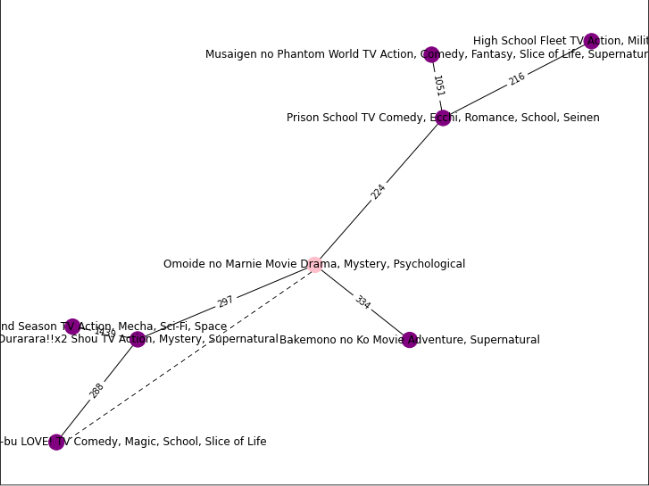

# Train-val-split

In [141]:
edge_splitter_test = EdgeSplitter(graph)
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.05, method="global")

print(nx.info(graph_test))

** Sampled 1038 positive and 1038 negative edges. **
Graph with 399 nodes and 19733 edges


In [142]:
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.05, method="global")
examples_train, examples_model_selection, labels_train, labels_model_selection = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(nx.info(graph_train))

** Sampled 986 positive and 986 negative edges. **
Graph with 399 nodes and 18747 edges


In [143]:
pd.DataFrame(
    [("Training", len(examples_train), "Train classifier"),
      ("Model Selection", len(examples_model_selection), "select the best link classifier model"),
     ("Test", len(examples_test), "evaluate the classifier")],
     columns=("Split", "Num ", "Purpose")).set_index("Split")

,Num,Purpose
Split,,
Training,1479,Train classifier
Model Selection,493,select the best link classifier model
Test,2076,evaluate the classifier


# node2vec models

In [ ]:
node2vec1 = Node2Vec(graph_train, dimensions=20, walk_length=5, num_walks=10, weight_key='weight')
model1 = node2vec1.fit(window=3, min_count=1)

node2vec2 = Node2Vec(graph_train, dimensions=30, walk_length=10, num_walks=15, weight_key='weight')
model2 = node2vec2.fit(window=4, min_count=1)

node2vec3 = Node2Vec(graph_train, dimensions=40, walk_length=14, num_walks=18, weight_key='weight')
model3 = node2vec3.fit(window=5, min_count=1)

node2vec4 = Node2Vec(graph_train, dimensions=50, walk_length=17, num_walks=20, weight_key='weight')
model4 = node2vec4.fit(window=6, min_count=1)

node2vec5 = Node2Vec(graph_train, dimensions=50, walk_length=25, num_walks=20, weight_key='weight')
model5 = node2vec5.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


In [148]:
models = [model1, model2, model3, model4, model5]

In [154]:
def plot_tsne(model):
  ne = model.wv.vectors
  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(ne)
  plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
  plt.show()

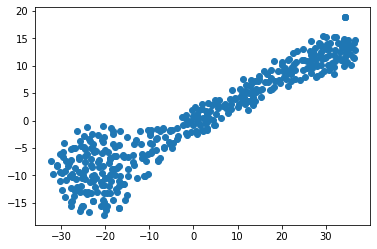

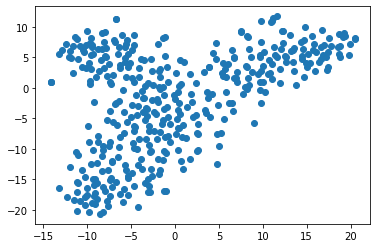

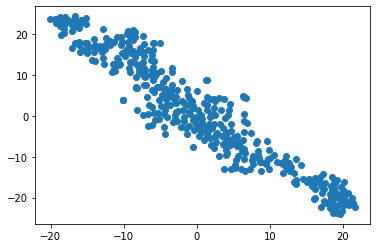

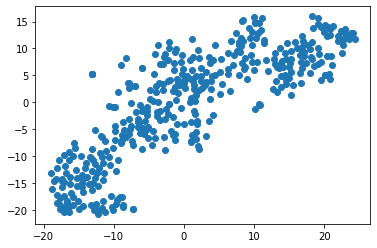

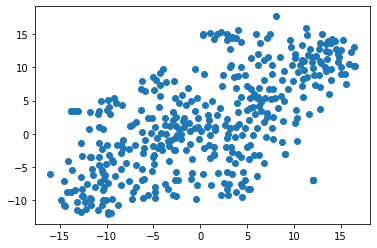

In [155]:
for i in models:
  plot_tsne(i)

# node2vec: find similar titles

In [17]:
nodes = []
for i in graph.nodes():
  nodes.append(i)

In [18]:
names_available = np.unique(nodes)

In [156]:
print(names_available[306], model1.wv.get_vector(names_available[306]))

Seikai no Senki III OVA Action, Military, Romance, Sci-Fi, Space [ 0.02040187 -0.01183153 -0.20249721 -0.19357839  0.10927671  0.0083498
 -0.08219334  0.6957441   0.28557718  0.3841621   0.23573686 -0.16321404
  0.12333705  0.4265731  -0.01183962  0.4556251   0.15095846 -0.28793964
 -0.11052457  0.00286184]


In [157]:
for node, score in model1.wv.most_similar('Seikai no Senki III OVA Action, Military, Romance, Sci-Fi, Space'):
  print(node, score)

Candy Candy TV Drama, Shoujo, Slice of Life 0.9986048340797424
Ar Tonelico: Sekai no Owari de Utai Tsuzukeru Shoujo OVA Action, Adventure, Fantasy, Magic, Sci-Fi 0.998546838760376
UFO Princess Valkyrie 3: Seiresetsu no Hanayome OVA Comedy, Magic, Romance, Sci-Fi 0.9985210299491882
Saiyuuki Reload Gunlock TV Action, Adventure, Comedy, Fantasy, Shoujo 0.9984890222549438
Gift: Eternal Rainbow Special Special Comedy, Ecchi, Harem, Magic, Romance 0.9984557628631592
Koi Kaze TV Drama, Psychological, Romance, Seinen 0.9984498023986816
Eiken: Eikenbu yori Ai wo Komete OVA Comedy, Ecchi, Harem, School 0.998391330242157
Mugen no Ryvius TV Drama, Mecha, Military, Psychological, Sci-Fi, Space 0.9983873963356018
Skull Man TV Action, Mystery, Super Power 0.9983243346214294
Mahoutsukai ni Taisetsu na Koto: Natsu no Sora TV Drama, Magic, Shounen, Slice of Life 0.9983227252960205


# Classification

In [158]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

In [159]:
def get_vectorized(link_features, model):
  s = []
  d = []
  for src, dst in link_features:
    s.append(model.wv[src])
    d.append(model.wv[dst])
  return np.array(s), np.array(d)

In [160]:
def apply_operator(s, d, op):
  transformed = op(s, d)
  return transformed

In [161]:
def do_classification(f_train, l_train, op, model):
  s, d = get_vectorized(f_train, model)
  X_train = op(s, d)
  y_train = l_train

  lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), cv=10, scoring="roc_auc", max_iter=1000)
  pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
  pipa.fit(X_train, y_train)

  return pipa

In [227]:
def evaluate(classif, f_test, l_test, op, model):
  s_test, d_test = get_vectorized(f_test, model)
  testing_labels = apply_operator(s_test, d_test, op)
  predicted = classif.predict_proba(testing_labels)
  predictedf1 = classif.predict(testing_labels)
  positive_column = list(classif.classes_).index(1)
  #return f1_score(l_test, predictedf1)
  return roc_auc_score(l_test, predicted[:, positive_column])

In [163]:
def run_prediction(op, model):
  clf = do_classification(examples_train, labels_train, op, model)
  score = evaluate(clf, examples_model_selection, labels_model_selection, op, model)
  return {
        "classifier": clf,
        "binary_operator": op,
        "score": score
    }

In [164]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [228]:
def show_best_op(model):
  results = [run_prediction(op, model) for op in binary_operators]
  best_result = max(results, key=lambda result: result["score"])

  print(f"Best result from '{best_result['binary_operator'].__name__}'")

  return pd.DataFrame(
      [(result["binary_operator"].__name__, result["score"]) for result in results],
      columns=("name", "ROC-AUC score"),
  ).set_index("name"), best_result

In [229]:
res1, best_result1 = show_best_op(model1)
res1

Best result from 'operator_avg'


,ROC-AUC score
name,
operator_hadamard,0.926005
operator_l1,0.767655
operator_l2,0.728771
operator_avg,0.930007


In [230]:
res2, best_result2 = show_best_op(model2)
res2

Best result from 'operator_hadamard'


,ROC-AUC score
name,
operator_hadamard,0.828755
operator_l1,0.714888
operator_l2,0.716765
operator_avg,0.823221


In [231]:
res3, best_result3 = show_best_op(model3)
res3

Best result from 'operator_avg'


,ROC-AUC score
name,
operator_hadamard,0.793544
operator_l1,0.780385
operator_l2,0.787039
operator_avg,0.795817


In [232]:
res4, best_result4 = show_best_op(model4)
res4

Best result from 'operator_hadamard'


,ROC-AUC score
name,
operator_hadamard,0.836594
operator_l1,0.802042
operator_l2,0.785804
operator_avg,0.832987


In [233]:
res5, best_result5 = show_best_op(model5)
res5

Best result from 'operator_avg'


,ROC-AUC score
name,
operator_hadamard,0.806242
operator_l1,0.791107
operator_l2,0.810507
operator_avg,0.829694


# Evaluation

## Get embeddings

In [241]:
node2vec1_test = Node2Vec(graph_test, dimensions=20, walk_length=5, num_walks=10, weight_key='weight')
model1_test = node2vec1_test.fit(window=3, min_count=1)

node2vec2_test = Node2Vec(graph_test, dimensions=30, walk_length=10, num_walks=15, weight_key='weight')
model2_test = node2vec2_test.fit(window=4, min_count=1)

node2vec3_test = Node2Vec(graph_test, dimensions=40, walk_length=14, num_walks=18, weight_key='weight')
model3_test = node2vec3_test.fit(window=5, min_count=1)

node2vec4_test = Node2Vec(graph_test, dimensions=50, walk_length=17, num_walks=20, weight_key='weight')
model4_test = node2vec4_test.fit(window=6, min_count=1)

node2vec5_test = Node2Vec(graph_test, dimensions=50, walk_length=25, num_walks=20, weight_key='weight')
model5_test = node2vec5_test.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


In [247]:
test_score1 = evaluate(
    best_result1["classifier"],
    examples_test,
    labels_test,
    best_result1["binary_operator"],
    model1_test,
)
print(f"ROC-AUC score on test set using '{best_result1['binary_operator'].__name__}': {test_score1}")

ROC-AUC score on test set using 'operator_avg': 0.9292529356514121


In [248]:
test_score2 = evaluate(
    best_result2["classifier"],
    examples_test,
    labels_test,
    best_result2["binary_operator"],
    model2_test,
)
print(f"ROC-AUC score on test set using '{best_result2['binary_operator'].__name__}': {test_score2}")

ROC-AUC score on test set using 'operator_hadamard': 0.7735594610949617


In [249]:
test_score3 = evaluate(
    best_result3["classifier"],
    examples_test,
    labels_test,
    best_result3["binary_operator"],
    model3_test,
)
print(f"ROC-AUC score on test set using '{best_result3['binary_operator'].__name__}': {test_score3}")

ROC-AUC score on test set using 'operator_avg': 0.6377732856649627


In [245]:
test_score4 = evaluate(
    best_result4["classifier"],
    examples_test,
    labels_test,
    best_result4["binary_operator"],
    model4_test,
)
print(f"ROC-AUC score on test set using '{best_result4['binary_operator'].__name__}': {test_score4}")

ROC-AUC score on test set using 'operator_hadamard': 0.5898459687928097


In [246]:
test_score5 = evaluate(
    best_result5["classifier"],
    examples_test,
    labels_test,
    best_result5["binary_operator"],
    model5_test,
)
print(f"ROC-AUC score on test set using '{best_result5['binary_operator'].__name__}': {test_score5}")

ROC-AUC score on test set using 'operator_avg': 0.4492827469455489


In [239]:
def plot_tsne(model):
  src_test, dst_test = get_vectorized(examples_test, model)
  test = operator_avg(src_test, dst_test)

  tsne2 = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
  ne_2d = tsne2.fit_transform(test)
  
  plt.figure(figsize=(10, 8))
  plt.scatter(test[:, 0], test[:, 1], c=np.where(labels_test == 1, "b", "r"), alpha=0.5)
  plt.show()

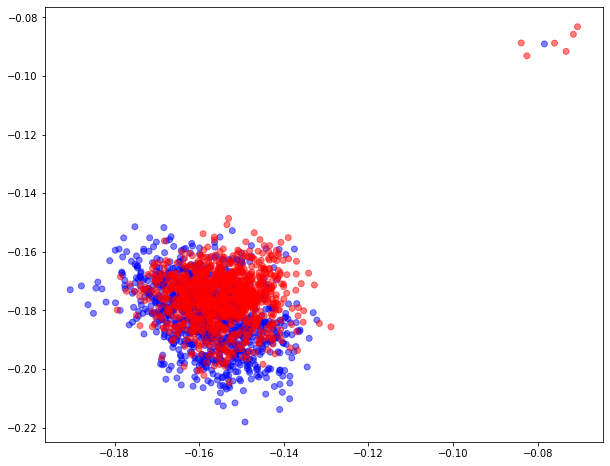

In [240]:
plot_tsne(model4_test)

# Plot ROC-AUC curve

In [208]:
s_train, d_train = get_vectorized(examples_model_selection, model4_test)
s_test, d_test = get_vectorized(examples_test, model4_test)
X_train = operator_avg(s_train, d_train)
X_test = operator_avg(s_test, d_test)
y_train = labels_model_selection
y_test = labels_test

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.712


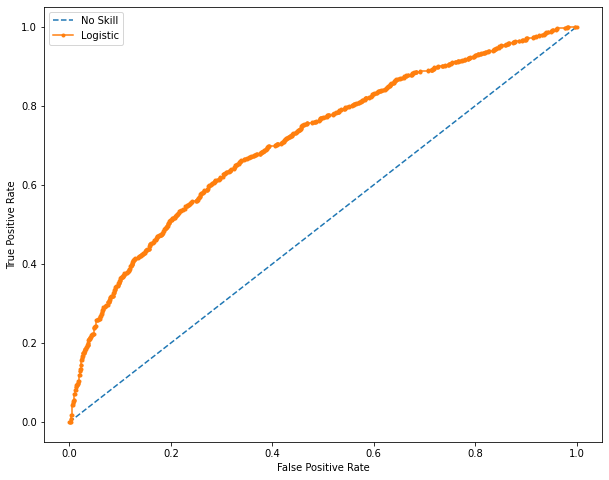

In [211]:
#roc_auc
ns_probs = [0 for _ in range(len(labels_test))]

lr_clf = LogisticRegressionCV(Cs=np.logspace(0.01, 1, 5), cv=10, scoring="roc_auc", max_iter=1000)
pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
pipa.fit(X_train, y_train)
lr_probs = lr_clf.predict_proba(X_test)
lr_probs1 = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs1)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs1)
# plot the roc curve for the model
plt.figure(figsize=(10, 8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [65]:
plt.savefig('/content/gdrive/My Drive/4 year/roccurve.png')

<Figure size 432x288 with 0 Axes>

## Plot Precision-Recall curve

Logistic: f1=0.667 auc=0.710


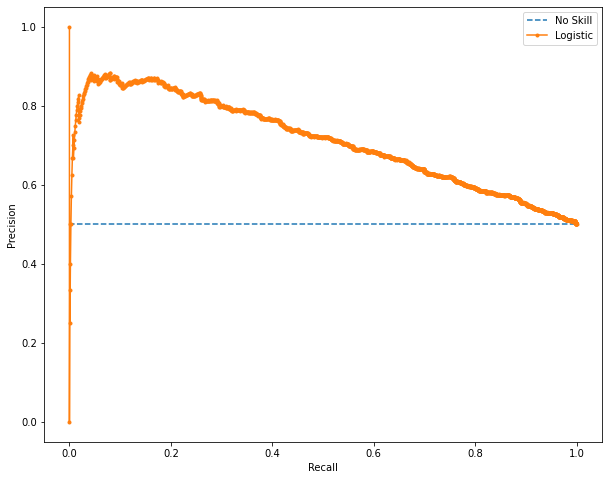

In [212]:
# predict class values
yhat = lr_clf.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs1)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [130]:
plt.savefig('/content/gdrive/My Drive/4 year/precreccurve.png')

<Figure size 432x288 with 0 Axes>

# Dump'n'Load

Train

In [214]:
pickle.dump(model4, open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'wb'))

In [ ]:
model4 = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_800.sav', 'rb'))

Test

In [213]:
pickle.dump(model4_test, open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'wb'))

In [ ]:
model4_test = pickle.load(open('/content/gdrive/My Drive/4 year/final_node2vec_test800.sav', 'rb'))